## Initialization

In [2]:
import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [3]:
directory = '/datasets/faces/final_files'
df = pd.read_csv('/datasets/faces/labels.csv')

In [4]:
datagen = ImageDataGenerator(rescale=1.0/255)

In [5]:
datagen_flow = datagen.flow_from_dataframe(dataframe=df,
                                           directory=directory,
                                           x_col='file_name',
                                           y_col='real_age',
                                           target_size=(224, 224),
                                           batch_size=32,
                                           class_mode='raw',
                                           seed=12345
                                          )

Found 7591 validated image filenames.


## EDA

In [6]:
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [8]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


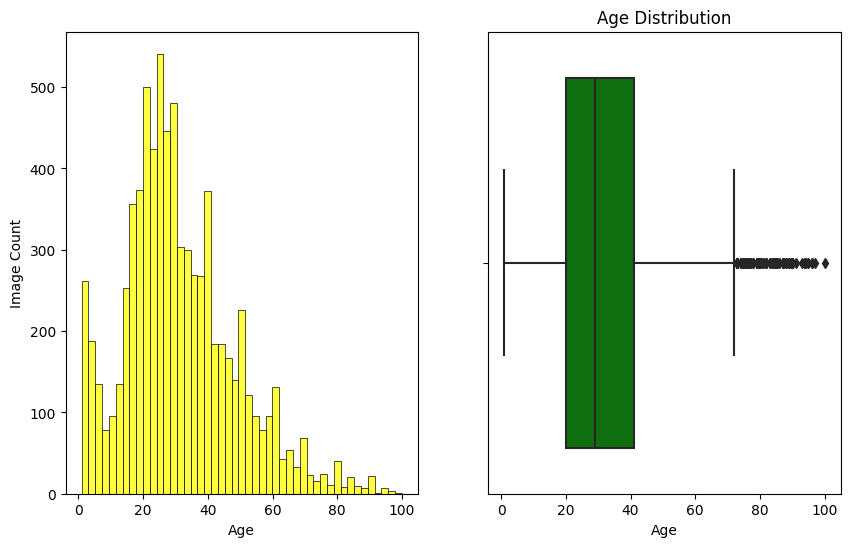

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
sns.boxplot(x='real_age', data=df, ax=ax[1], color='green')
plt.title('Age Distribution')
sns.histplot(data=df, x='real_age', ax=ax[0], color='yellow')
ax[1].set(xlabel='Age')
ax[0].set(xlabel='Age', ylabel='Image Count')
plt.show()

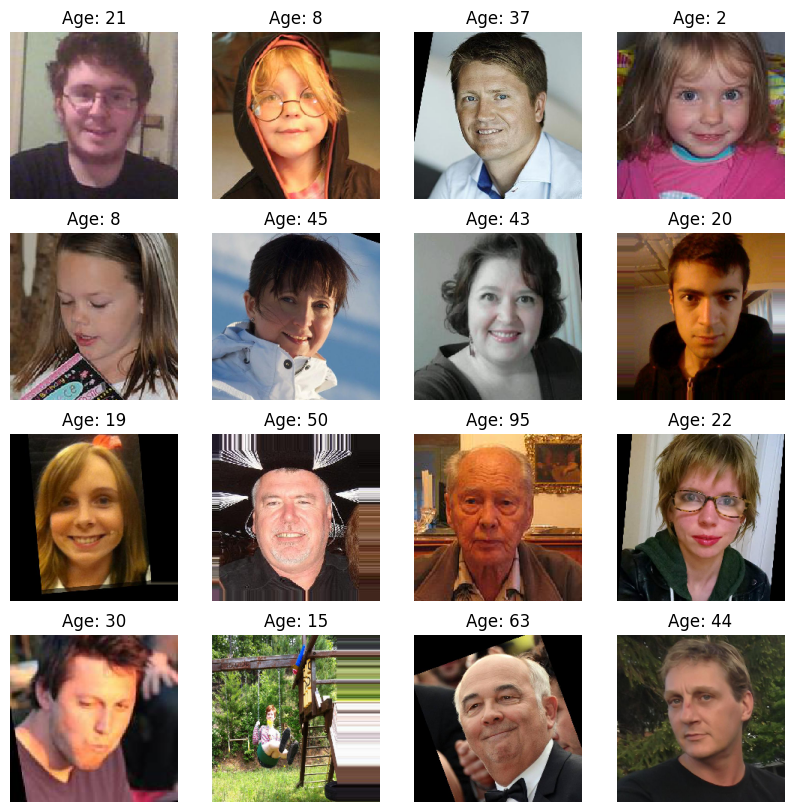

In [31]:
file_name, age_num = next(datagen_flow)

# check 16 randomly selected files with the real ages
fig = plt.figure(figsize=(10, 10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    age = age_num[i]
    image = file_name[i]
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Age: {age}')

### Findings

* There are 7591 validated images with real ages attached 
* The ages range from 0-100 years old
* The majority of images contain folks who are between 20-40 years old, with an average age of about 31, and median age of about 29  
* Many of the images feature headshots, however some are zoomed out and include the entire body of the person in various settings
* The images vary among race, ethnicity, and gender
* Most of the images appear to be centered, however many are off-center and rotated at an angle as to not fit the frame.
* Many of the images feature people looking directly at the camera, while others are looking off to the side of the shot, or away from the lens
* The images vary in brightness, sharpness, clarity, resolution, distortion, and color

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [ ]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [3]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1.0/255, horizontal_flip=True)
    
    train_gen_flow = train_datagen.flow_from_dataframe(dataframe=pd.read_csv(path+'labels.csv'),
                                                       directory=path+'final_files/',
                                                       x_col='file_name',
                                                       y_col='real_age',
                                                       target_size=(244, 244),
                                                       batch_size=16,
                                                       class_mode='raw',
                                                       subset='training',
                                                       seed=12345
                                                      )

    return train_gen_flow

In [4]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1.0/255)
    
    test_gen_flow = test_datagen.flow_from_dataframe(dataframe=pd.read_csv(path+'labels.csv'),
                                                     directory=path+'final_files/',
                                                     x_col='file_name',
                                                     y_col='real_age',
                                                     target_size=(244, 244),
                                                     batch_size=16,
                                                     class_mode='raw',
                                                     subset='validation',
                                                     seed=12345
                                                    )

    return test_gen_flow

In [5]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    backbone = ResNet50(input_shape=input_shape,
                       weights='imagenet',
                       include_top=False
                       )
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001), metrics=['mae'])
    
    return model

In [6]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
        
    model.fit(train_data,
             validation_data=test_data,
             epochs=epochs,
             steps_per_epoch=steps_per_epoch,
             validation_steps=validation_steps,
             verbose=2
             )

    return model

In [ ]:
if __name__ == "__main__":
    train_data = load_train('/datasets/faces/')
    test_data = load_test('/datasets/faces/')
    model = create_model(train_data[0].shape[1:])
    model = train_model(model, train_data, test_data)

### Prepare the Script to Run on the GPU Platform

In [ ]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')